In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score
from sklearn.linear_model import Ridge


Mounted at /content/drive


In [5]:
df = pd.read_csv('Statewise Consumption.csv')
df.head()

,States,Regions,latitude,longitude,Dates,Usage
0,Punjab,NR,31.519974,75.980003,02/01/2019 00:00:00,119.9
1,Haryana,NR,28.450006,77.019991,02/01/2019 00:00:00,130.3
2,Rajasthan,NR,26.449999,74.639981,02/01/2019 00:00:00,234.1
3,Delhi,NR,28.669993,77.230004,02/01/2019 00:00:00,85.8
4,UP,NR,27.599981,78.050006,02/01/2019 00:00:00,313.9


# New section

In [6]:
# Data Cleaning
df = df.drop_duplicates()


null_rows = df[df.isnull().any(axis=1)]


df_clean = df.dropna()


print("Number of rows with null values:", len(null_rows))
print("Number of rows removed:", len(df) - len(df_clean))


df_clean.reset_index(drop=True, inplace=True)


Number of rows with null values: 0
Number of rows removed: 0


In [7]:
# Feature Engineering

df['Dates'] = pd.to_datetime(df['Dates'], format="%d/%m/%Y %H:%M:%S")

df['Dates'] = pd.to_datetime(df['Dates'])

from sklearn.cluster import KMeans


n_clusters = 5


kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(df[['latitude', 'longitude']])


df['cluster_label'] = kmeans.labels_



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [8]:
df.head()

,States,Regions,latitude,longitude,Dates,Usage,cluster_label
0,Punjab,NR,31.519974,75.980003,2019-01-02,119.9,1
1,Haryana,NR,28.450006,77.019991,2019-01-02,130.3,1
2,Rajasthan,NR,26.449999,74.639981,2019-01-02,234.1,1
3,Delhi,NR,28.669993,77.230004,2019-01-02,85.8,1
4,UP,NR,27.599981,78.050006,2019-01-02,313.9,1


In [9]:
# Extract temporal features
df['day_of_week'] = df['Dates'].dt.dayofweek
df['day_of_week'] = df['day_of_week'].map({0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"})

df['month'] = df['Dates'].dt.month
month_names = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

df['month'] = df['month'].map(month_names)
df['year'] = df['Dates'].dt.year
df['season'] = df['Dates'].dt.month % 12 // 3
df['season'] = df['season'].map({0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Fall'})

In [10]:


# Historical Averages
df['historical_avg_usage'] = df.groupby(['States', 'month'])['Usage'].transform('mean')

# Day Type
def get_day_type(day):
    if day in ['Saturday', 'Sunday']:
        return 'Weekend'
    else:
        return 'Weekday'

df['day_type'] = df['day_of_week'].apply(get_day_type)

# Convert 'Dates' column to datetime format
df['Dates'] = pd.to_datetime(df['Dates'], format="%d/%m/%Y %H:%M:%S")

# Extract quarter information
df['quarter'] = df['Dates'].dt.quarter

# Filter data for the years 2019 and 2020
df_2019 = df[df['year'] == 2019].copy()
df_2020 = df[df['year'] == 2020].copy()

# Define quarter labels
quarter_labels = {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4'}

# Map quarter numbers to quarter labels
df_2019['quarter_label'] = df_2019['quarter'].map(quarter_labels)
df_2020['quarter_label'] = df_2020['quarter'].map(quarter_labels)



In [11]:
df.head()

,States,Regions,latitude,longitude,Dates,Usage,cluster_label,day_of_week,month,year,season,historical_avg_usage,day_type,quarter
0,Punjab,NR,31.519974,75.980003,2019-01-02,119.9,1,Wednesday,January,2019,Winter,157.712963,Weekday,1
1,Haryana,NR,28.450006,77.019991,2019-01-02,130.3,1,Wednesday,January,2019,Winter,150.764815,Weekday,1
2,Rajasthan,NR,26.449999,74.639981,2019-01-02,234.1,1,Wednesday,January,2019,Winter,213.350000,Weekday,1
3,Delhi,NR,28.669993,77.230004,2019-01-02,85.8,1,Wednesday,January,2019,Winter,95.275926,Weekday,1
4,UP,NR,27.599981,78.050006,2019-01-02,313.9,1,Wednesday,January,2019,Winter,329.481481,Weekday,1


In [12]:
# Analysis: What day of the week has the highest energy consumption?
avg_usage_by_day = df.groupby('day_of_week')['Usage'].mean()
day_with_highest_usage = avg_usage_by_day.idxmax()
print("Day of the week with highest energy consumption:", day_with_highest_usage)

Day of the week with highest energy consumption: Tuesday


In [13]:
# Analysis: Which month has the highest energy consumption?
avg_usage_by_month = df.groupby('month')['Usage'].mean()
month_with_highest_usage = avg_usage_by_month.idxmax()
print("Month with highest energy consumption:", month_with_highest_usage)

Month with highest energy consumption: August


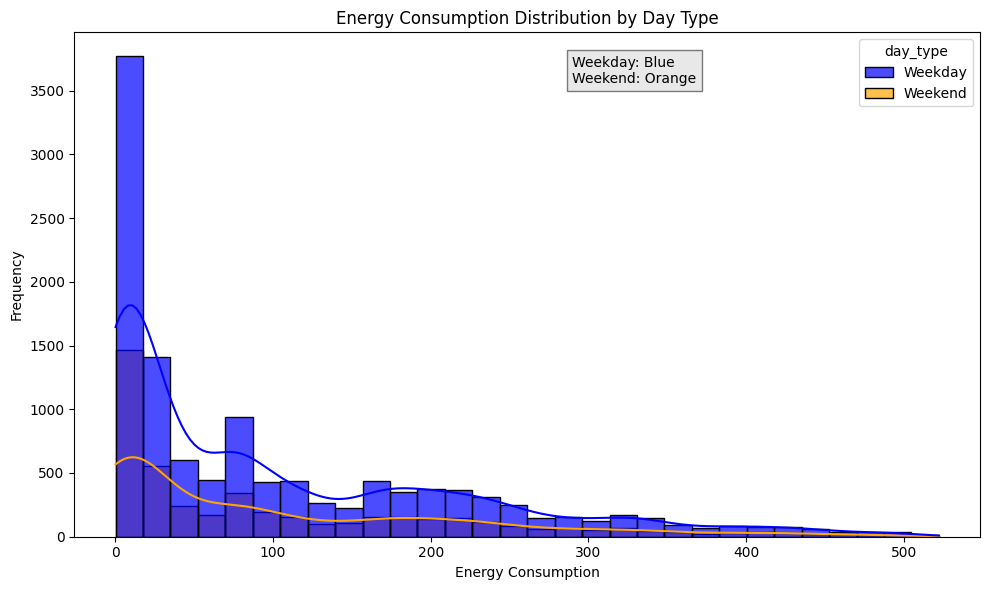

In [14]:
weekday_color = 'blue'
weekend_color = 'orange'

# Histogram of energy consumption for weekdays and weekends
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Usage', hue='day_type', bins=30, kde=True, palette={'Weekday': weekday_color, 'Weekend': weekend_color}, alpha=0.7)
plt.title('Energy Consumption Distribution by Day Type')
plt.xlabel('Energy Consumption')
plt.ylabel('Frequency')

plt.text(0.55, 0.9, 'Weekday: Blue\nWeekend: Orange', transform=plt.gca().transAxes, fontsize=10, bbox=dict(facecolor='lightgray', alpha=0.5))
plt.tight_layout()
plt.show()



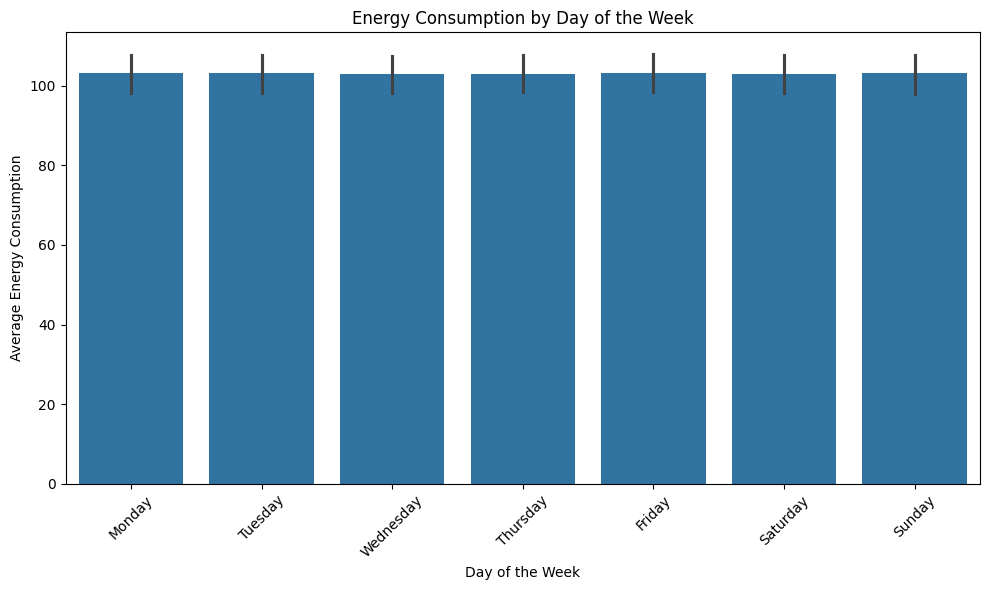

In [15]:

# Analysis: Energy consumption trends by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x='day_of_week', y='Usage', data=df, estimator=np.mean, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Energy Consumption by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Energy Consumption')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

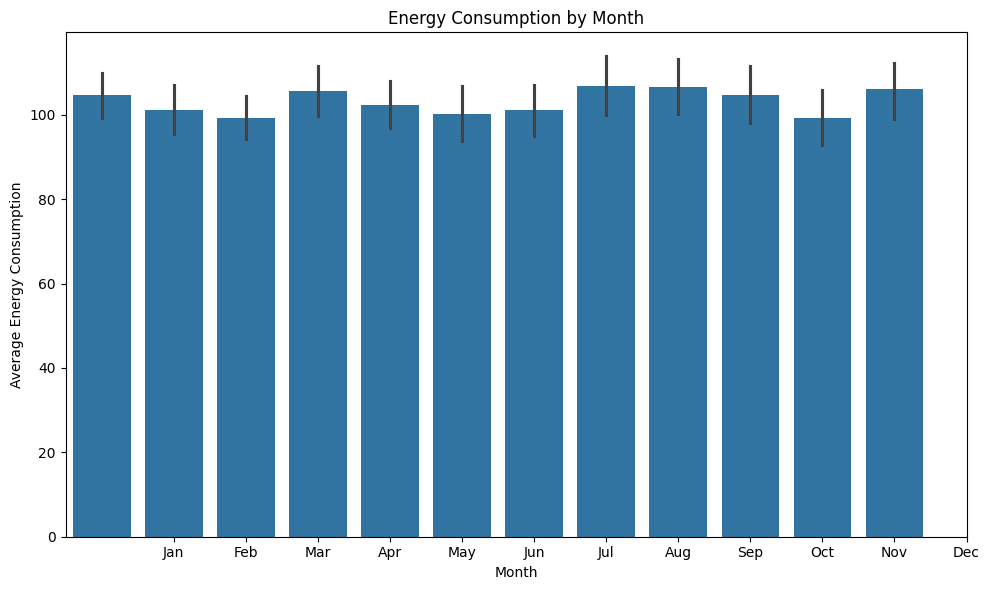

In [16]:
# Analysis: Energy consumption trends by month
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='Usage', data=df, estimator=np.mean)
plt.title('Energy Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Average Energy Consumption')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

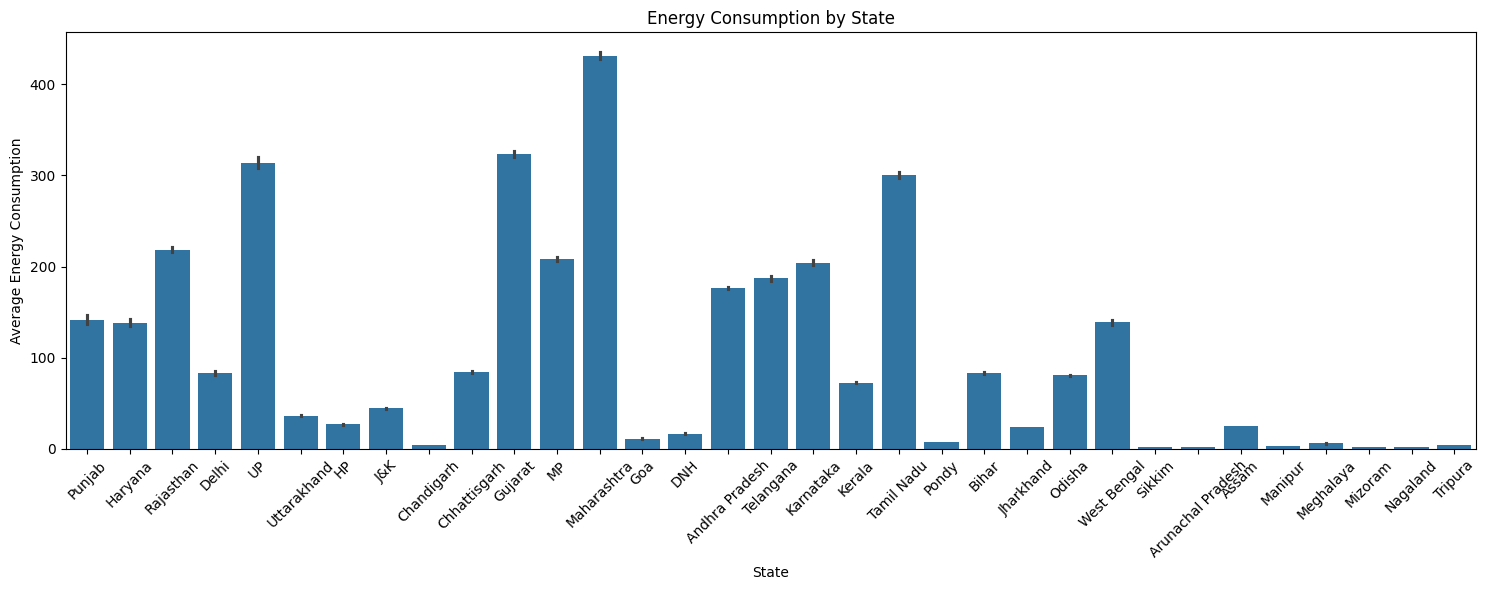

In [17]:
# Analysis: Energy consumption trends by state
plt.figure(figsize=(15, 6))
sns.barplot(x='States', y='Usage', data=df, estimator=np.mean)
plt.title('Energy Consumption by State')
plt.xlabel('State')
plt.ylabel('Average Energy Consumption')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


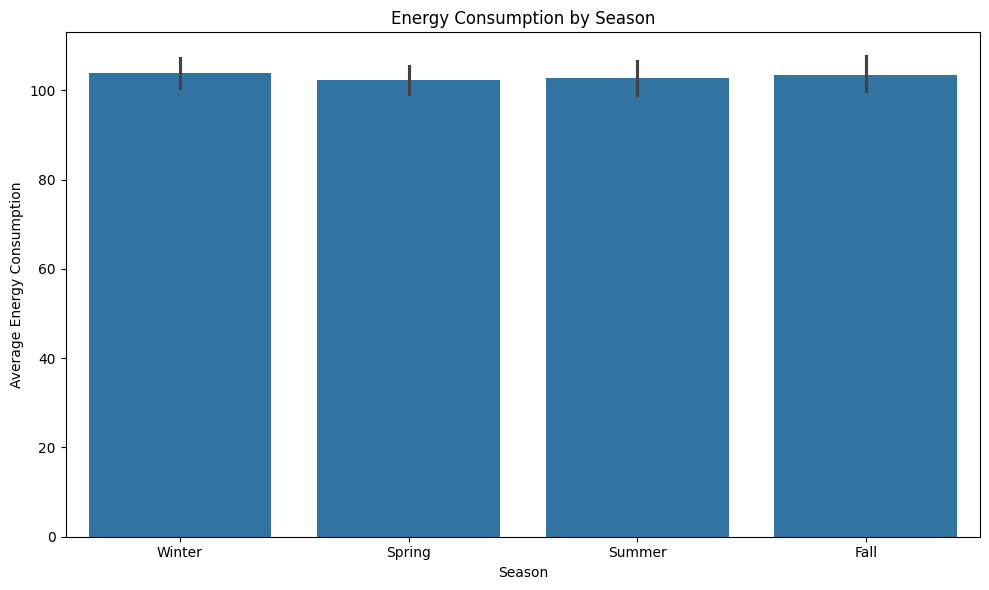

In [18]:
# Analysis: Energy consumption trends by season
plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='Usage', data=df, estimator=np.mean, order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('Energy Consumption by Season')
plt.xlabel('Season')
plt.ylabel('Average Energy Consumption')
plt.tight_layout()
plt.show()


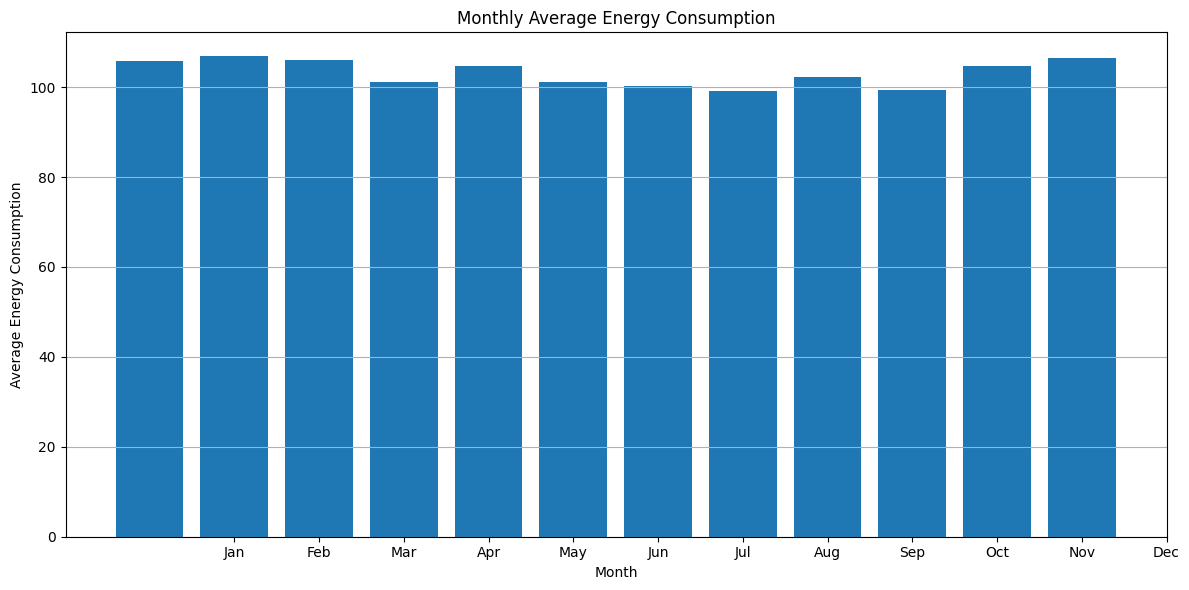

In [19]:
# Analysis: Monthly Energy Consumption
monthly_consumption = df.groupby('month')['Usage'].mean()
plt.figure(figsize=(12, 6))
plt.bar(monthly_consumption.index, monthly_consumption.values)
plt.title('Monthly Average Energy Consumption')
plt.xlabel('Month')
plt.ylabel('Average Energy Consumption')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

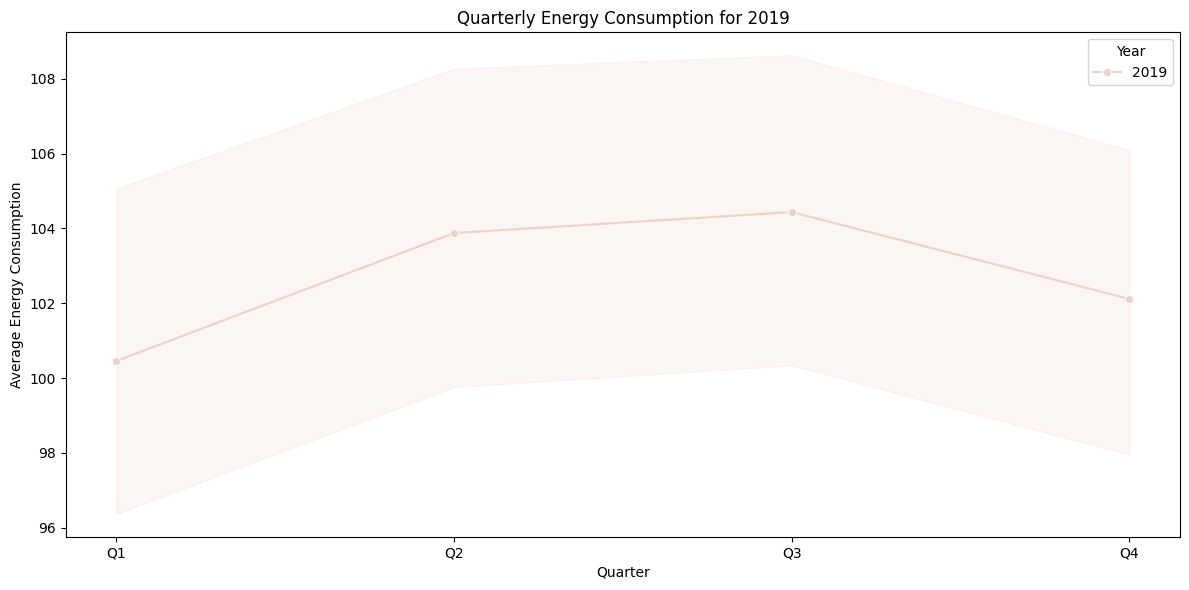

In [20]:
# Analysis: Quarterly Energy Consumption for 2019 (Line Plot)
plt.figure(figsize=(12, 6))
sns.lineplot(x='quarter_label', y='Usage', data=df_2019, hue='year', estimator=np.mean, marker='o')
plt.title('Quarterly Energy Consumption for 2019')
plt.xlabel('Quarter')
plt.ylabel('Average Energy Consumption')
plt.legend(title='Year')
plt.tight_layout()
plt.show()




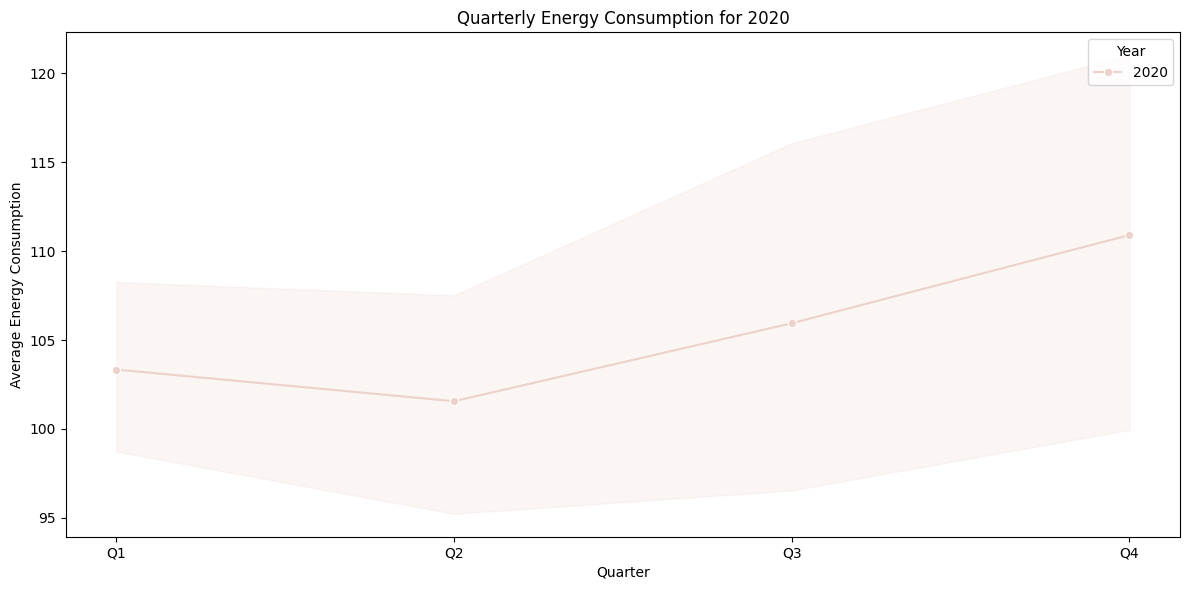

In [21]:

# Analysis: Quarterly Energy Consumption for 2020 (Line Plot)
plt.figure(figsize=(12, 6))
sns.lineplot(x='quarter_label', y='Usage', data=df_2020, hue='year', estimator=np.mean, marker='o')
plt.title('Quarterly Energy Consumption for 2020')
plt.xlabel('Quarter')
plt.ylabel('Average Energy Consumption')
plt.legend(title='Year')
plt.tight_layout()
plt.show()

Good work👍

# **Model Building**

**Linear Regression**

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
# Prepare the data
X = df[['States', 'Regions']]
y = df['Usage']  # Target variable
# Perform one-hot encoding on categorical features
X_encoded = pd.get_dummies(X)


In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize the linear regression model
model = LinearRegression()

In [25]:
# Fit the model to the training data
model.fit(X_train, y_train)


LinearRegression()

In [26]:
# Make predictions on the testing data
predictions = model.predict(X_test)


In [27]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)

In [28]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Explained Variance Score: {explained_variance}")

Root Mean Squared Error (RMSE): 24.093066644179594
Mean Absolute Error (MAE): 13.848649412296563
R-squared (R²): 0.9564918362446444
Mean Absolute Percentage Error (MAPE): 0.20118827694833785
Explained Variance Score: 0.9565293061263651


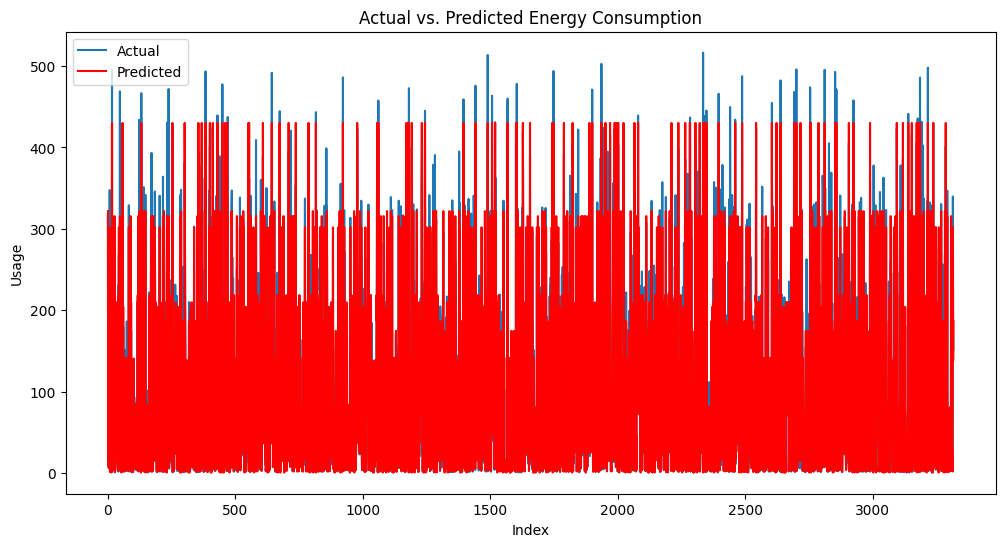

In [29]:
# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Energy Consumption')
plt.xlabel('Index')
plt.ylabel('Usage')
plt.legend()
plt.show()

Space for Remarks:

> Add blockquote




**Model- Neural Network**

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

In [31]:
# Prepare the data
X = df[['States', 'Regions']]
y = df['Usage']  # Target variable
# Perform one-hot encoding on categorical features
X_encoded = pd.get_dummies(X)

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
# Initialize the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

In [34]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Fit the model to the training data
history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, verbose=1)


Epoch 1/100
332/332 [==============================] - 2s 5ms/step - loss: 10352.9961 - mae: 56.4501 - val_loss: 802.2418 - val_mae: 17.6659
Epoch 2/100
332/332 [==============================] - 1s 4ms/step - loss: 612.5189 - mae: 14.3289 - val_loss: 632.6645 - val_mae: 13.7838
Epoch 3/100
332/332 [==============================] - 1s 3ms/step - loss: 593.7275 - mae: 13.6055 - val_loss: 638.6367 - val_mae: 13.7144
Epoch 4/100
332/332 [==============================] - 1s 2ms/step - loss: 590.0728 - mae: 13.4905 - val_loss: 633.7520 - val_mae: 13.7254
Epoch 5/100
332/332 [==============================] - 1s 2ms/step - loss: 591.8448 - mae: 13.5422 - val_loss: 647.0156 - val_mae: 13.8270
Epoch 6/100
332/332 [==============================] - 1s 2ms/step - loss: 595.6703 - mae: 13.5710 - val_loss: 642.6866 - val_mae: 13.7374
Epoch 7/100
332/332 [==============================] - 1s 2ms/step - loss: 597.0740 - mae: 13.5705 - val_loss: 669.3807 - val_mae: 13.8043
Epoch 8/100
332/332 [====

In [35]:
# Make predictions on the testing data
predictions = model.predict(X_test_scaled).flatten()


104/104 [==============================] - 0s 1ms/step


In [36]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)

In [37]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Explained Variance Score: {explained_variance}")


Root Mean Squared Error (RMSE): 24.289601596647227
Mean Absolute Error (MAE): 13.583980374094807
R-squared (R²): 0.9557791207442711
Mean Absolute Percentage Error (MAPE): 0.14612819467478114
Explained Variance Score: 0.9561099090493826


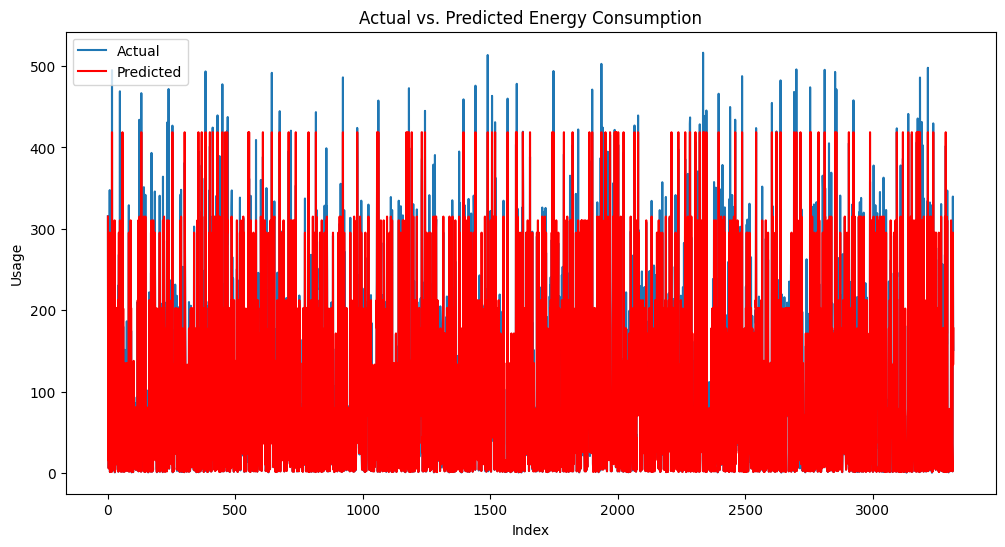

In [38]:
# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Energy Consumption')
plt.xlabel('Index')
plt.ylabel('Usage')
plt.legend()
plt.show()

**RandomForest Regressor**

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score


In [40]:
# Prepare the data
X = df[['States', 'Regions']]
y = df['Usage']  # Target variable
# Perform one-hot encoding on categorical features
X_encoded = pd.get_dummies(X)

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize the random forest regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [42]:
# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = model.predict(X_test)

In [43]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)

In [44]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Explained Variance Score: {explained_variance}")

Root Mean Squared Error (RMSE): 24.071490919232488
Mean Absolute Error (MAE): 13.634755593292315
R-squared (R²): 0.956569725860654
Mean Absolute Percentage Error (MAPE): 0.14796681638997286
Explained Variance Score: 0.9566105503454317


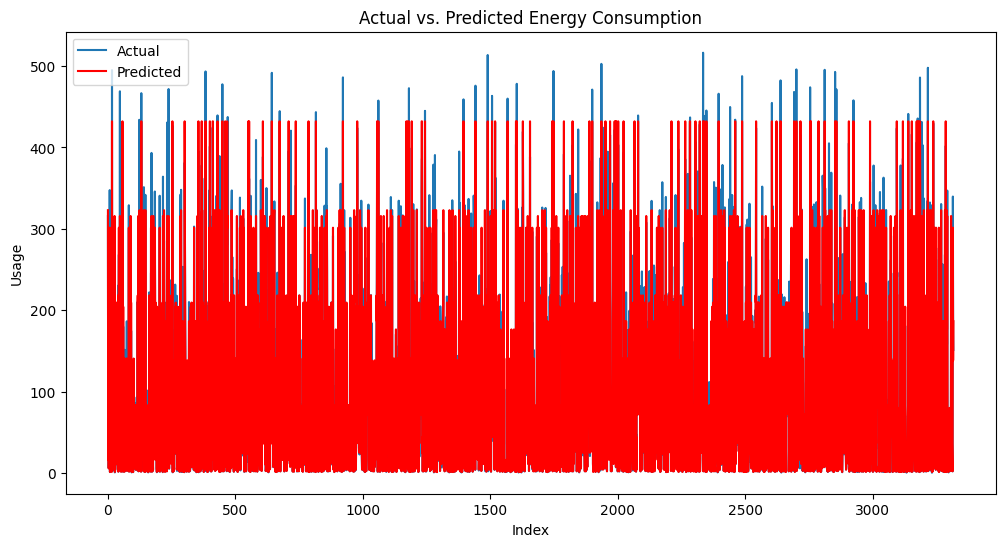

In [45]:
# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Energy Consumption')
plt.xlabel('Index')
plt.ylabel('Usage')
plt.legend()
plt.show()

**LSTM Model**

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt
import numpy as np

In [61]:
# Encode the 'States' column
state_encoder = OneHotEncoder()
states_encoded = state_encoder.fit_transform(df[['States']]).toarray()

In [62]:
# Add year as a feature
df['year'] = df['Dates'].dt.year

# Prepare the exogenous variables (year and state)
exog = np.hstack([states_encoded, df[['year']]])

In [63]:
# Prepare the target variable
y = df['Usage'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(exog, y, test_size=0.2, random_state=42)


In [64]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [65]:
# Reshape the input data for LSTM (samples, timesteps, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [66]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [67]:
# Fit the model to the training data
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
415/415 [==============================] - 5s 5ms/step - loss: 20536.0527
Epoch 2/50
415/415 [==============================] - 1s 3ms/step - loss: 7641.7661
Epoch 3/50
415/415 [==============================] - 1s 3ms/step - loss: 2012.4897
Epoch 4/50
415/415 [==============================] - 1s 3ms/step - loss: 911.1428
Epoch 5/50
415/415 [==============================] - 1s 3ms/step - loss: 654.7534
Epoch 6/50
415/415 [==============================] - 1s 3ms/step - loss: 604.9329
Epoch 7/50
415/415 [==============================] - 1s 3ms/step - loss: 597.0592
Epoch 8/50
415/415 [==============================] - 1s 3ms/step - loss: 596.3680
Epoch 9/50
415/415 [==============================] - 1s 3ms/step - loss: 595.7586
Epoch 10/50
415/415 [==============================] - 2s 4ms/step - loss: 594.4389
Epoch 11/50
415/415 [==============================] - 2s 5ms/step - loss: 595.1513
Epoch 12/50
415/415 [==============================] - 1s 3ms/step - loss: 595.26

In [68]:
# Make predictions on the testing data
predictions = model.predict(X_test_scaled)


104/104 [==============================] - 1s 2ms/step


In [69]:
# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
explained_variance = explained_variance_score(y_test, predictions)

In [70]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Explained Variance Score: {explained_variance}")

Root Mean Squared Error (RMSE): 24.20726451040726
Mean Absolute Error (MAE): 13.661446549663925
R-squared (R²): 0.9560784131931676
Mean Absolute Percentage Error (MAPE): 0.14817568133311726
Explained Variance Score: 0.956179963749238


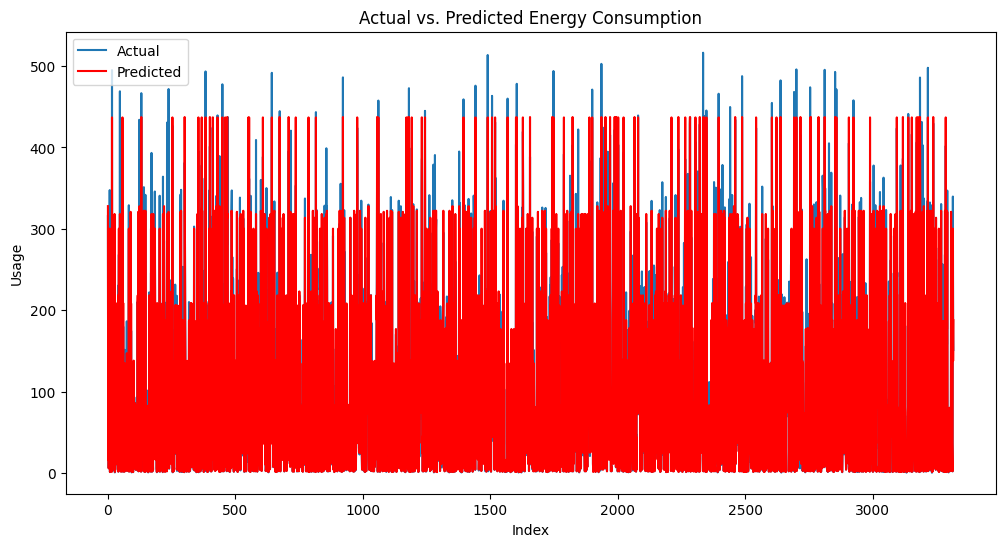

In [71]:
# Plot the actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.title('Actual vs. Predicted Energy Consumption')
plt.xlabel('Index')
plt.ylabel('Usage')
plt.legend()
plt.show()